<a href="https://colab.research.google.com/github/hemanths03/CS6910_Assignment_2/blob/main/Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing WandB

In [112]:
#Install WandB
!pip install wandb

#Importing the Required Libraries

In [113]:
#Importing some Required Libraries
import wandb
import cv2 , numpy as np
from wandb.keras import WandbCallback
from tensorflow import keras
import random
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm.notebook import tqdm
import tensorflow as tf
from wandb.keras import WandbCallback
import imageio
import os
import cv2
import glob

#Importing Regularizers
from keras import regularizers

#For Data generation
from keras.preprocessing.image import ImageDataGenerator , img_to_array , load_img , image

#Import the required models
from tensorflow.keras.models import Sequential, Model, load_model

#Import the required layers
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,AveragePooling2D,Dropout,BatchNormalization,Activation

#Import some other Libraries
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.optimizers import Adadelta,Adam

#Importing the activation functions
from tensorflow.keras.activations import relu,softmax

#Importing initializers
from tensorflow.keras.initializers import he_normal,glorot_normal,random_normal,glorot_uniform

#Importing losses
from tensorflow.keras.losses import categorical_crossentropy

#Importing classbacks
from tensorflow.keras.callbacks import EarlyStopping

#Importing backend as k
from tensorflow.keras import backend as K

#WandB Login

In [114]:
!wandb login

wandb: Currently logged in as: cs21m027_cs21m011 (use `wandb login --relogin` to force relogin)


#Get the Dataset

In [115]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip

--2022-03-31 06:49:05--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip.1’

nature_12K.zip.1     11%[=>                  ] 416.73M  60.2MB/s    eta 35s    ^C


#Unzip the Dataset

In [5]:
!unzip 'nature_12K.zip'

Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

#Load train and test path

In [116]:
train = 'inaturalist_12K/train'
test = 'inaturalist_12K/val'

#Declare the Labels

In [117]:
labels = ["Amphibia", "Animalia", "Arachnida", "Aves", "Fungi", "Insecta", "Mammalia", "Mollusca", "Plantae", "Reptilia"]

#Function show_images (to display sample images of all classes)

In [118]:
def show_images(train_path , labels):

  train_gen = ImageDataGenerator().flow_from_directory(directory = train_path,color_mode = 'rgb',class_mode = 'categorical')
  paths = train_gen.filepaths
  k = 0
  m = 0
  n = 0
  plot = []
  fig, axes = plt.subplots(2, 5, figsize=(12.5,6))
  classes = train_gen.classes
  for i in range(len(paths)):
    if classes[i] == k:
        ax = axes[m,n]
        img = load_img(paths[i] ,target_size = (256,256))
        ax.imshow(img)
        ax.set_title("Class: "+str(classes[i])+","+"Label: "+str(labels[classes[i]]))
        #plot.append(wandb.Image(train_images[i],caption= 'Class='+str(train_labels[i])+', Label='+str(desc[train_labels[i]])))
        n=n+1
        k=k+1
        if(n==5):
          m=1
          n=0
        if k==10:
          break
  plt.tight_layout()
  plt.suptitle("Sample Images of All classes")
  plt.show()


Found 9999 images belonging to 10 classes.


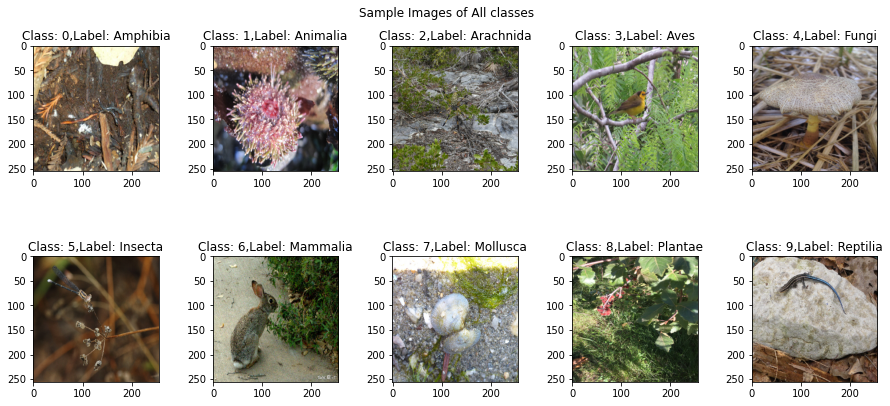

In [119]:
show_images(train , labels)

#Helper function

In [120]:
def helper(model , test_data):

    np.random.seed(77)
    
    print("Test Accuracy and 30 random Images with True and Predicted Labels : ")
    
    #predictions
    ypred = model.predict(test_data).argmax(axis=1)
    
    ytrue = test_data.classes

    #Test Accuracy
    test_acc = np.sum(ypred == ytrue)/len(ytrue)
    print("Test accuracy", test_acc)

    wandb.log( { "test_accuracy": test_acc} )



    #dict1
    maps = test_data.class_indices
    #idx_to_class
    ids = {v:k for k,v in maps.items()}

    #test_image_paths
    paths = test_data.filepaths

    #rnd_idx
    rid = np.random.choice(len(paths),30,replace=False)
    #ix
    var = 1

    plt.figure(figsize=(10,30))

    for i in rid:
      ax = plt.subplot(10,3,var)
      img = load_img(paths[i],target_size=(224,224))
      ax.set_xticks([])
      ax.set_yticks([])
      true_label = ids[ytrue[i]]
      pred_label = ids[ypred[i]]

      ax.set_xlabel("True : " + str(true_label));ax.xaxis.label.set_color('black')
      ax.set_ylabel("Pred : " + str(pred_label));ax.yaxis.label.set_color('black')

      plt.imshow(img)

      var += 1
    plt.show()


#Filter Vizualisation

In [121]:
def filter_visualization():

    np.random.seed(77)
    
    print("First convolutional layer filter visualization :")

    model = keras.models.load_model("final_model")

    index = 0

    for i in range(len(model.layers)):
        if "conv" in model.layers[i].name:
            index = i
            break

    conv_layer_1 = model.layers[index]
    filters = conv_layer_1.get_weights()[0]

    #Filter Normalization
    filters = (filters - filters.min()) / (filters.max() - filters.min())

    #Plot the Filters
    n = filters.shape[3]
    rows,cols = int(np.sqrt(n)),int(np.sqrt(n))

    fig = plt.figure(figsize=(rows*1, cols*1))
    plt.axis('off') 
    plt.title("Filter visualisation of first convolutional layer")
    item=1

    for i in range(n):
        cf = filters[:, :, :, i]

        ax = fig.add_subplot(rows, cols, item)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.imshow(cf)
        item += 1

    plt.show()
    plt.savefig('filter_visualise.png')

#Random image filter visualization

In [122]:
def image_filter_visualization(test_data):

    np.random.seed(77)
        
    print("First convolutional layer filter visualization for random Test Image:")

    paths = test_data.filepaths
    
    id = np.random.choice(len(paths),1,replace=False)
    
    test_image = load_img(paths[int(id)],target_size=(224,224))
    
    model = keras.models.load_model("final_model")
    
    new_model = Model(inputs = model.inputs , outputs = model.layers[0].output)

    plt.imshow(test_image)
    plt.axis('off')
    plt.title('Test image')
    ip_img = img_to_array(test_image)
    ip_img = ip_img.reshape((1,)+ip_img.shape)
    ip_img/=255.0
    

    fmaps = new_model.predict(ip_img)
    num_fmaps = fmaps.shape[3]
    ix = 1
    plt.figure(figsize = (10,6))
    for i in range(num_fmaps):

       ax = plt.subplot(8,8,ix)
       ax.set_xticks([])
       ax.set_yticks([])
       plt.imshow(fmaps[0,:,:,ix-1])
       ix+=1

    plt.suptitle("Feature maps of random Test image of first convolution layer")
    plt.show()

#Guided Backpropagation

In [123]:
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast( x > 0, "float32") * dy
    return tf.nn.relu(x), grad

In [147]:
def guided_backprop(test_data):
    
    np.random.seed(77)
    
    paths = test_data.filepaths
    
    id = np.random.choice(len(paths),1,replace=False)
    
    test_image = load_img(paths[int(id)],target_size=(224,224))
    
    plt.imshow(test_image)
    plt.axis('off')
    plt.title('Random Test image')
    
    model = keras.models.load_model('final_model')
    
    image_tensor = np.expand_dims(test_image, axis = 0)

    # Applying the guided Relu on activation layers 
    for layer in model.layers[1:]:
        if hasattr(layer, 'activation') and layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu

    grads = []
    imgs = []

    for pl in range(10):
      i = random.randrange(0,63)

      #[2,3,7,11,15,21,23,26,29,61]
      #i = random.range(0,63)
 
      op = tf.keras.activations.relu(model.get_layer("conv2d_4").output[:,:,:,i])
      n = tf.keras.models.Model(inputs = [model.inputs],outputs = [op])

      #gradients 
      with tf.GradientTape() as g:
        inputs = tf.cast(image_tensor, tf.float32)
        g.watch(inputs)
        outputs = n(inputs)

      grads.append(g.gradient(outputs,inputs).numpy()[0])

    for gd in grads:
      gm = np.dstack((gd[:, :, 0],gd[:, :, 1],gd[:, :, 2],))       
      gm = gm - np.min(gm)
      gm = gm/gm.max()
      imgs.append(gm)

    var = 1
    figure = plt.figure(figsize=(20, 20.))
    grid = ImageGrid(figure, 111 , nrows_ncols=(2, 5),axes_pad=0.3)

    for axes, img in zip(grid, imgs):
        axes.imshow(img)
        axes.axis('off')
        axes.set_title("Feature map : "+str(var))
        var+=1
    plt.show()
    plt.savefig("guided_bak_prop.png")

#Train function Used to train the Model

In [136]:
def train():

    np.random.seed(77)
    
    #Initializing WandB
    run = wandb.init()
    config=run.config

    #Setting up the Run name
    name = "fs_" + str(config.filter_size) + "_nf_" + str(config.num_filters) + "_do_" + str(config.dropout)
    run.name = name

    #Setting the target Image size
    target_size = (224,224)

    #set the parameters
    (H , W , D) = (224 , 224 , 3)
    
    epochs = 20

    #Defing the input_shape for the model
    input_shape = (H , W , D)

    train_path = 'inaturalist_12K/train'
    test_path = 'inaturalist_12K/val'

    if config.data_aug == "Yes":
      train_datagen = ImageDataGenerator(rescale = 1./255,
                                        rotation_range = 30,
                                        validation_split = 0.1,
                                        zoom_range = 0.2,
                                        horizontal_flip = True,
                                        shear_range = 12
                                        )

      test_datagen = ImageDataGenerator(rescale = 1./255)
                                        
    else:
      train_datagen = ImageDataGenerator(rescale = 1./255,
                                        validation_split = 0.1)
      

      test_datagen = ImageDataGenerator(rescale = 1./255)

    
    #Getting the training data
    train_set = train_datagen.flow_from_directory(directory = train_path,
                                                  target_size = target_size,
                                                  color_mode = 'rgb',
                                                  batch_size = config.batch_size,
                                                  class_mode = 'categorical',
                                                  seed = 10,
                                                  subset = 'training'
                                                  )
    
    #Getting the validation data
    val_set = train_datagen.flow_from_directory(directory = train_path,
                                                target_size = target_size,
                                                color_mode = 'rgb',
                                                batch_size = config.batch_size,
                                                class_mode = 'categorical',
                                                seed = 10,
                                                subset = 'validation'
                                                )
    
    #Getting the Test data
    test_data = test_datagen.flow_from_directory(directory = test_path,
                                               target_size = target_size,
                                               color_mode = 'rgb',
                                               batch_size = 1,
                                               class_mode = None,
                                               shuffle = False,
                                               seed=10
                                               )
    
    test_data.reset()

  
    # Defining the Model 
    num_filters = [config.num_filters]*5
    filter_size = [(config.filter_size)]*5
    pool_size = [(config.pool_size)]*5
    ac = [config.ac]*5
    
    #Updating num_filters based filter organization
    if config.filter_org == 2:
        for i in range(1, 5) : num_filters[i] = int(num_filters[i - 1] * 2)
    elif config.filter_org == 0.5:
        for i in range(1, 5) : num_filters[i] = int(num_filters[i - 1] / 2)
    
    # Model Defination
    model = Sequential()

    for i in range(5):
        model.add(Conv2D(num_filters[i], filter_size[i], input_shape = (H, W, D)))
        model.add(Activation(ac[i]))
        if config.batch_norm == "Yes" : model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = pool_size[i]))
        if config.batch_norm == "Yes" : model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(config.num_neurons, activation = 'relu'))
    if config.batch_norm == "Yes" : model.add(BatchNormalization())
    model.add(Dropout(config.dropout))
    model.add(Dense(len(labels), activation = 'softmax'))

    # Model Compilation
    model.compile(
        'adam', 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
        )

    # Model Training
    model.fit(
        train_set,
        steps_per_epoch = ceil((float) (train_set.n) / train_set.batch_size),
        epochs = epochs,
        callbacks = [WandbCallback()],
        validation_data = val_set,
        validation_steps = ceil((float) (val_set.n) / val_set.batch_size)
    )

    #predictions
    #ypred = model.predict(test_data).argmax(axis=1)
    
    #ytrue = test_data.classes

    #Test Accuracy
    #test_acc = np.sum(ypred == ytrue)/len(ytrue)
    #print("Test accuracy", test_acc)
    

    model.save("final_model")

    helper(model , test_data)
    
    filter_visualization()
    
    image_filter_visualization(test_data)
    
    guided_backprop(test_data)

    run.finish()

#Sweep Configuration 

In [137]:
sweep_config_temp = {
  "name": "FINAL_BEST_MODEL",

  "method": "grid",

  "metric": {
      "name": "accuracy",
      "goal": "maximize"  
    },
  "parameters": {
        "filter_size" : {
            "values" : [3]
        },
        "pool_size" : {
            "values" : [2]
        },
        "ac" : {
            "values" : ["relu"]
        },
        "num_filters" : {
            "values" : [64]
        },
        "filter_org" : {
            "values" : [1]
        },
        "data_aug" : {
            "values" : ["Yes"]
        },
        "dropout" : {
            "values" : [0.2]
        },
        "batch_norm" : {
            "values" : ["Yes"]
        },
        "weight_decay" : {
            "values" : [0.01]
        },
        "batch_size" : {
            "values" : [128]
        },
        "num_neurons" : {
            "values" : [256]
        }
    }
}

#Setting the sweep id

In [138]:
sweep_id = wandb.sweep(sweep_config_temp, entity="cs21m027_cs21m011", project="DL_ASG_2_final_Part_A")

Create sweep with ID: ez5l7ds0
Sweep URL: https://wandb.ai/cs21m027_cs21m011/DL_ASG_2_final_Part_A/sweeps/ez5l7ds0


#Starting the Sweeps

wandb: Agent Starting Run: cohmme5e with config:
wandb: 	ac: relu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 128
wandb: 	data_aug: Yes
wandb: 	dropout: 0.2
wandb: 	filter_org: 1
wandb: 	filter_size: 3
wandb: 	num_filters: 64
wandb: 	num_neurons: 256
wandb: 	pool_size: 2
wandb: 	weight_decay: 0.01


Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/20
71/71 [==============================] - 246s 3s/step - loss: 2.3562 - accuracy: 0.2241 - val_loss: 2.5804 - val_accuracy: 0.0931 - _timestamp: 1648709949.0000 - _runtime: 260.0000
Epoch 2/20
71/71 [==============================] - 233s 3s/step - loss: 2.0688 - accuracy: 0.2828 - val_loss: 2.7938 - val_accuracy: 0.1011 - _timestamp: 1648710182.0000 - _runtime: 493.0000
Epoch 3/20
71/71 [==============================] - 231s 3s/step - loss: 1.9632 - accuracy: 0.3211 - val_loss: 2.7902 - val_accuracy: 0.1281 - _timestamp: 1648710413.0000 - _runtime: 724.0000
Epoch 4/20
71/71 [==============================] - 236s 3s/step - loss: 1.8964 - accuracy: 0.3469 - val_loss: 2.8565 - val_accuracy: 0.1311 - _timestamp: 1648710649.0000 - _runtime: 960.0000
Epoch 5/20
71/71 [==============================] - 233s 3s/step - loss: 1.8462 - accuracy: 0.3596 - val

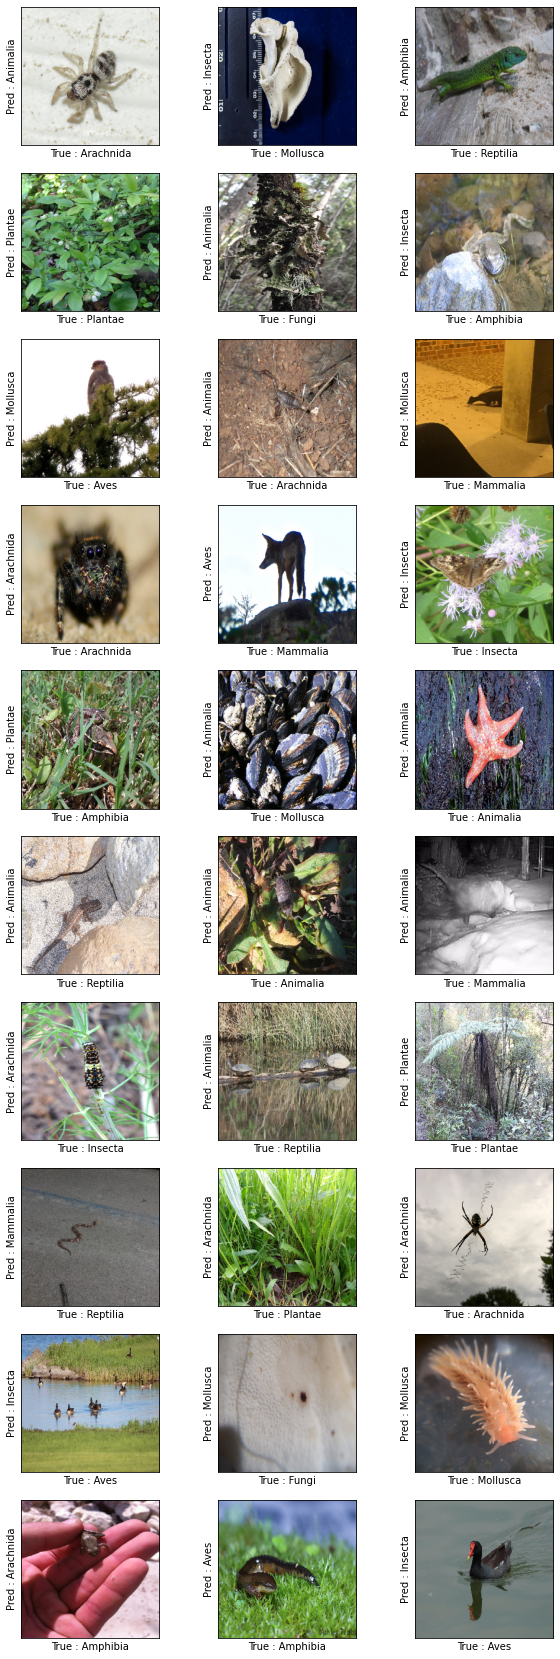

First convolutional layer filter visualization :


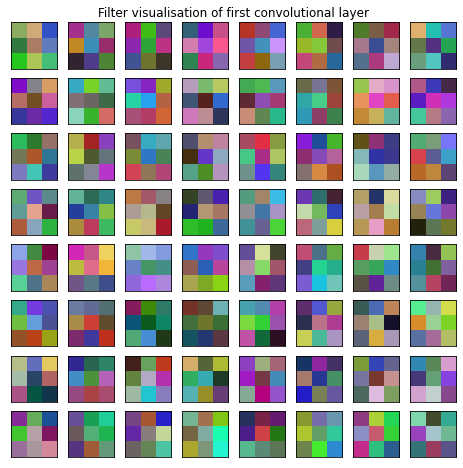

First convolutional layer filter visualization for random Test Image:


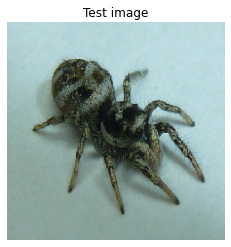

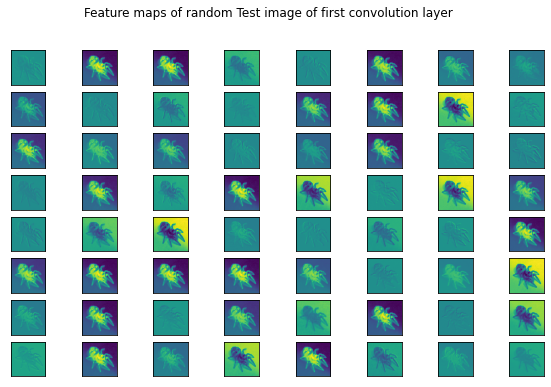

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


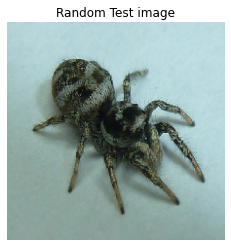

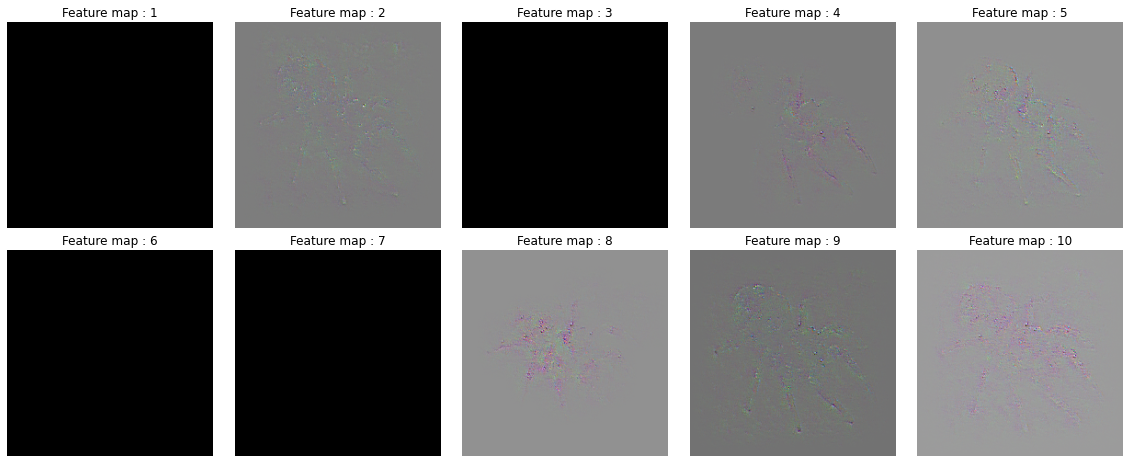

accuracy,▁▂▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
test_accuracy,▁
val_accuracy,▁▁▂▂▂▃▄▅▇▅▆▅▇▆▇▅▇▇█▇
val_loss,▆████▄▄▃▂▄▂▆▃▃▃▆▂▂▁▂
accuracy,0.54022
best_epoch,18
best_val_loss,1.75484
epoch,19
loss,1.32031


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


<Figure size 432x288 with 0 Axes>

In [139]:
wandb.agent(sweep_id, train)